In [1]:
!nvidia-smi

Sun Nov 21 12:25:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/HW2/hw2_data.zip

串流輸出內容已截斷至最後 5000 行。
 extracting: hw2_data/face/train/31182.png  
 extracting: hw2_data/face/train/35296.png  
 extracting: hw2_data/face/train/29882.png  
  inflating: hw2_data/face/train/21095.png  
 extracting: hw2_data/face/train/23957.png  
  inflating: hw2_data/face/train/30313.png  
 extracting: hw2_data/face/train/11616.png  
 extracting: hw2_data/face/train/10447.png  
 extracting: hw2_data/face/train/34172.png  
 extracting: hw2_data/face/train/35917.png  
 extracting: hw2_data/face/train/18720.png  
 extracting: hw2_data/face/train/10484.png  
 extracting: hw2_data/face/train/25579.png  
 extracting: hw2_data/face/train/11294.png  
 extracting: hw2_data/face/train/21343.png  
 extracting: hw2_data/face/train/30592.png  
 extracting: hw2_data/face/train/05946.png  
 extracting: hw2_data/face/train/36061.png  
 extracting: hw2_data/face/train/07383.png  
 extracting: hw2_data/face/train/05793.png  
 extracting: hw2_data/face/train/04351.png  
 extracting: hw2_data/face/train/2

In [4]:
import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image, ImageEnhance, ImageOps
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.utils import save_image
from tqdm import tqdm

In [ ]:
!rm -r /content/tsne

In [ ]:
os.system('mkdir /content/tsne/')

def sample_image(s, t, dir_name):
  # randomly sample 5000 image from source domain and target domain 
  source = '/content/hw2_data/digits/%s/test'%s
  target = '/content/hw2_data/digits/%s/test'%t

  try:
    os.system('mkdir /content/tsne/%s'%dir_name)
  except:
    pass

  s_df = pd.read_csv('/content/hw2_data/digits/%s/test.csv'%s).sample(n=2000, random_state=1)
  t_df = pd.read_csv('/content/hw2_data/digits/%s/test.csv'%t).sample(n=2000, random_state=1)

  for i in tqdm(range(len(s_df))):
    image = s_df['image_name'].iloc[i]
    label = s_df['label'].iloc[i]
    os.system('cp ' + source + '/' + image + ' ' + '/content/tsne/%s/%s_s_%s.png'%(dir_name, label, str(i)))

  for i in tqdm(range(len(t_df))):
    image = t_df['image_name'].iloc[i]
    label = t_df['label'].iloc[i]
    os.system('cp ' + target + '/' + image + ' ' + '/content/tsne/%s/%s_t_%s.png'%(dir_name, label, str(i)))


sample_image('svhn', 'mnistm', 'svhn_mnistm')
sample_image('mnistm', 'usps', 'mnistm_usps')
sample_image('usps', 'svhn', 'usps_svhn')

100%|██████████| 2000/2000 [00:22<00:00, 87.27it/s]


# Dataloader

In [23]:
class Image_Dataset(Dataset):
    def __init__(self, root, train=True, trans=None):
      self.train = train
      self.root = root
      self.transform = trans
      self.data_name = pd.read_csv(self.root + self.train + '.csv')['image_name'].tolist()
      self.data_label = pd.read_csv(self.root + self.train + '.csv')['label'].tolist()

    def __getitem__(self, index):
      self.img = Image.open(self.root + self.train + '/' + self.data_name[index])
      self.img = self.transform(self.img)
      self.label = self.data_label[index]
      return (self.img, self.label, self.data_name[index])

    def __len__(self):
      return len(self.data_name)

class Tsen_Dataset(Dataset):
    def __init__(self, root, trans=None):
      self.root = root
      self.transform = trans
      self.dataset = os.listdir(self.root)

    def __getitem__(self, index):

      self.label = self.dataset[index].split('_')[0]
      
      if self.dataset[index].split('_')[1] == 's':
        self.domain = 0 
      else:
        self.domain = 1

      self.img = Image.open(self.root + '/' + self.dataset[index])
      self.img = self.transform(self.img)

      return (self.img, self.label, self.domain)

    def __len__(self):
      return len(self.dataset)


# Architecture

In [6]:
from torch.autograd import Function

class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class SVHNmodel(nn.Module):
    """ SVHN architecture
    """

    def __init__(self, batchnorm, dropout):
        super(SVHNmodel, self).__init__()
        self.restored = False
        self.batchnorm = batchnorm
        self.dropout = dropout

        if self.batchnorm & self.dropout:
          self.feature = nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5)),  # 28
              nn.BatchNorm2d(64),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2)),  # 13
              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 5)),  # 9
              nn.BatchNorm2d(64),
              nn.Dropout2d(),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2)),  # 4
              nn.ReLU(inplace=True),
              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4, 4)),  # 1
          )
        else:
          self.feature = nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5)),  # 28
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2)),  # 13
              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 5)),  # 9
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2)),  # 4
              nn.ReLU(inplace=True),
              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4, 4)),  # 1
          )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 1 * 1, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

        self.discriminator = nn.Sequential(
            nn.Linear(128 * 1 * 1, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2),
        )

    def forward(self, d_classifier, input_data, alpha = 1.0):
        input_data = input_data.expand(input_data.data.shape[0], input_data.data.shape[1], 32, 32)
        feature = self.feature(input_data)
        feature = feature.view(-1, 128 * 1 * 1)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.classifier(feature)
        if d_classifier:
          domain_output = self.discriminator(reverse_feature)

          return class_output, domain_output
        else:
          return class_output

class MNISTMmodel(nn.Module):
    """ MNIST-M architecture
    """
    def __init__(self, batchnorm, dropout):
        super(MNISTMmodel, self).__init__()
        self.restored = False
        self.batchnorm = batchnorm
        self.dropout = dropout

        if self.batchnorm & self.dropout:
          self.feature = nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=32,
                        kernel_size=(5, 5)),  # 3 28 28, 32 24 24
              nn.BatchNorm2d(32),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=(2, 2)),  # 32 12 12
              nn.Conv2d(in_channels=32, out_channels=48,
                        kernel_size=(5, 5)),  # 48 8 8
              nn.BatchNorm2d(48),
              nn.Dropout2d(),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=(2, 2)),  # 48 4 4
          )
        else:
              self.feature = nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=32,
                        kernel_size=(5, 5)),  # 3 28 28, 32 24 24
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=(2, 2)),  # 32 12 12
              nn.Conv2d(in_channels=32, out_channels=48,
                        kernel_size=(5, 5)),  # 48 8 8
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=(2, 2)),  # 48 4 4
          )

        self.classifier = nn.Sequential(
            nn.Linear(48*4*4, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
        )

        self.discriminator = nn.Sequential(
            nn.Linear(48*4*4, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 2),
        )

    def forward(self, d_classifier, input_data, alpha = 1.0):
        input_data = input_data.expand(input_data.data.shape[0], input_data.data.shape[1], 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, 48 * 4 * 4)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.classifier(feature)
        if d_classifier:
          domain_output = self.discriminator(reverse_feature)

          return class_output, domain_output
        else:
          return class_output



        

In [7]:

# Init weights for layers w.r.t. the original paper.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Training Function

In [36]:
from itertools import cycle

def adjust_learning_rate(optimizer, p):
    lr_0 = 0.01
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p)**beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def save_model(net, filename):
    """Save trained model."""
    torch.save(net.state_dict(), '/content/drive/MyDrive/HW2/model/DANN/%s'%filename)
    print("save pretrained model successful")

def train(model, src_data_loader, tgt_data_loader, tgt_data_loader_eval, device, n_epochs, l_step, save_modle_name):

    ####################
    # 1. train network #
    ####################
    global_step = 0
    best = {0:1}
    for epoch in range(n_epochs):
        # set train state for Dropout and BN layers
        model.train()
        # zip source and target data pair
        len_dataloader = min(len(src_data_loader), len(tgt_data_loader))

        if len(src_data_loader) > len(tgt_data_loader):
          data_zip = enumerate(zip(src_data_loader, cycle(tgt_data_loader)))
        else:
          data_zip = enumerate(zip(cycle(src_data_loader), tgt_data_loader))
        # data_zip = enumerate(zip(src_data_loader, tgt_data_loader))

        for step, ((images_src, class_src), (images_tgt, _)) in data_zip:

            p = float(step + epoch * len_dataloader) / n_epochs / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            lr = adjust_learning_rate(optimizer, p)

            # prepare domain label
            size_src = len(images_src)
            size_tgt = len(images_tgt)
            label_src = torch.zeros(size_src).long().to(device)  # source 0
            label_tgt = torch.ones(size_tgt).long().to(device)  # target 1

            # make images variable
            class_src = class_src.to(device)
            images_src = images_src.to(device)
            images_tgt = images_tgt.to(device)

            # zero gradients for optimizer
            optimizer.zero_grad()

            # train on source domain
            src_class_output, src_domain_output = model(d_classifier=True, input_data=images_src, alpha=alpha)
            src_loss_class = criterion(src_class_output, class_src)
            src_loss_domain = criterion(src_domain_output, label_src)

            # train on target domain
            _, tgt_domain_output = model(d_classifier=True, input_data=images_tgt, alpha=alpha)
            tgt_loss_domain = criterion(tgt_domain_output, label_tgt)

            loss = src_loss_class + src_loss_domain + tgt_loss_domain

            # optimize dann
            loss.backward()
            optimizer.step()

            global_step += 1

            # print step info

            if ((step + 1) % l_step == 0):
                print(
                    "Epoch [{:4d}/{}] Step [{:2d}/{}]: src_loss_class={:.6f}, src_loss_domain={:.6f}, tgt_loss_domain={:.6f}, loss={:.6f}"
                    .format(epoch + 1, n_epochs, step + 1, len_dataloader, src_loss_class.data.item(), src_loss_domain.data.item(), tgt_loss_domain.data.item(), loss.data.item()))

        # eval model
        if ((epoch + 1) % 1 == 0):
            src_test_loss, src_acc, tgt_acc_domain = test(model, src_data_loader, device, flag='source', train_source=False)
            tgt_test_loss, tgt_acc, src_acc_domain = test(model, tgt_data_loader_eval, device, flag='target', train_source=False)

        if (tgt_acc) > min(best):
            del_pth = best.pop(min(list(best.keys())))
            best[tgt_acc] = epoch
            
            try:
              os.system('rm -r /content/drive/MyDrive/HW2/model/DANN/%s_best.pth'%(save_modle_name))
            except:
              pass
            torch.save(model.state_dict(),  '/content/drive/MyDrive/HW2/model/DANN/%s_best.pth'%(save_modle_name))
    
    # torch.save(model.state_dict(),  '/content/drive/MyDrive/HW2/model/DANN/%s_%s.pth'%(save_modle_name, 'last'))
    # return model

def test(model, data_loader, device, flag, train_source):
    """Evaluate model for dataset."""
    # set eval state for Dropout and BN layers
    model.eval()

    # init loss and accuracy
    loss_ = 0.0
    acc_ = 0.0
    acc_domain_ = 0.0
    n_total = 0
    lab = []
    i_id = []
    # evaluate network
    for (images, labels, imagename) in data_loader:
        for i in imagename:
          i_id.append(i)
        images = images.to(device)
        labels = labels.to(device)  #labels = labels.squeeze(1)
        size = len(labels)
        if flag == 'target':
            labels_domain = torch.ones(size).long().to(device)
            
        else:
            labels_domain = torch.zeros(size).long().to(device)

        if train_source:
          preds = model(d_classifier=False, input_data=images, alpha=0)
        
        else:
          preds, domain = model(d_classifier=True, input_data=images, alpha=0)
          pred_domain = domain.data.max(1)[1]
          acc_domain_ += pred_domain.eq(labels_domain.data).sum().item()
          n_total += size
        
        # logits = model(True, images)[0]

        loss_ += criterion(preds, labels).item()
        pred_cls = preds.data.max(1)[1]
        for i in pred_cls:
          lab.append(i.cpu().item())
        

        acc_ += pred_cls.eq(labels.data).sum().item()
        
        try:
          acc_domain = acc_domain_ / n_total
        except:
          pass
        

    loss = loss_ / n_total
    acc = acc_ / n_total
    
    outputfile = pd.DataFrame(data={'image_name': i_id, 'label': lab})
    outputfile.to_csv('/content/test_pred1.csv', index=False)

    try:
      print("Avg Loss = {:.6f}, Avg Accuracy = {:.2%}, {}/{}, Avg Domain Accuracy = {:2%}".format(loss, acc, acc_, n_total, acc_domain))
    except:
      print("Avg Loss = {:.6f}, Avg Accuracy = {:.2%}, {}/{}".format(loss, acc, acc_, n_total))

    if train_source:
      return loss, acc
    else:
      return loss, acc, acc_domain

def test(model, data_loader, device, flag, train_source):
    """Evaluate model for dataset."""
    # set eval state for Dropout and BN layers
    model.eval()

    # init loss and accuracy
    loss_ = 0.0
    acc_ = 0.0
    acc_domain_ = 0.0
    n_total = 0
    lab = []
    i_id = []
    # evaluate network
    for (images, labels, imagename) in data_loader:
        for i in imagename:
          i_id.append(i)
        images = images.to(device)
        labels = labels.to(device)  #labels = labels.squeeze(1)
        size = len(labels)
        if flag == 'target':
            labels_domain = torch.ones(size).long().to(device)
            
        else:
            labels_domain = torch.zeros(size).long().to(device)

        if train_source:
          preds = model(d_classifier=False, input_data=images, alpha=0)
        
        else:
          preds, domain = model(d_classifier=True, input_data=images, alpha=0)
          pred_domain = domain.data.max(1)[1]
          acc_domain_ += pred_domain.eq(labels_domain.data).sum().item()
          n_total += size
        
        # logits = model(True, images)[0]

        loss_ += criterion(preds, labels).item()
        pred_cls = preds.data.max(1)[1]
        for i in pred_cls:
          lab.append(i.cpu().item())
        

        acc_ += pred_cls.eq(labels.data).sum().item()
        
        try:
          acc_domain = acc_domain_ / n_total
        except:
          pass
        

    loss = loss_ / n_total
    acc = acc_ / n_total
    
    outputfile = pd.DataFrame(data={'image_name': i_id, 'label': lab})
    outputfile.to_csv('/content/test_pred1.csv', index=False)

    try:
      print("Avg Loss = {:.6f}, Avg Accuracy = {:.2%}, {}/{}, Avg Domain Accuracy = {:2%}".format(loss, acc, acc_, n_total, acc_domain))
    except:
      print("Avg Loss = {:.6f}, Avg Accuracy = {:.2%}, {}/{}".format(loss, acc, acc_, n_total))

    if train_source:
      return loss, acc
    else:
      return loss, acc, acc_domain

# SVHN → MNIST-M

In [9]:
image_size = 32
batch_size = 64
num_epochs = 10
lr = 0.01
momentum = 0.9
weight_decay = 1e-6
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")


In [10]:
tfm_3 = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

## Prepare dataset 

In [37]:
s_train_set = Image_Dataset('/content/hw2_data/digits/svhn/', train='train', trans=tfm_3)
s_test_set = Image_Dataset('/content/hw2_data/digits/svhn/', train='test', trans=tfm_3)

t_train_set = Image_Dataset('/content/hw2_data/digits/mnistm/', train='train', trans=tfm_3)
t_test_set = Image_Dataset('/content/hw2_data/digits/mnistm/', train='test', trans=tfm_3)

s_data_loader = DataLoader(s_train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
s_data_loader_eval = DataLoader(s_test_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
t_data_loader = DataLoader(t_train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
t_data_loader_eval = DataLoader(t_test_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

dann = SVHNmodel(batchnorm=False, dropout=False)
dann.apply(weights_init)
dann.to(device)

optimizer = optim.SGD(dann.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Training on source domain and target domain data

In [ ]:
# os.listdir('/content/drive/MyDrive/HW2/model/DANN')
# os.system('rm -r /content/drive/MyDrive/HW2/model/DANN/DANN_SVHN_to_MNIST-M*')

In [ ]:
dann = train(dann, s_data_loader, t_data_loader, t_data_loader_eval, device, num_epochs, 200, 'DANN_SVHN_to_MNIST-M')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [   1/10] Step [200/938]: src_loss_class=0.524304, src_loss_domain=0.482375, tgt_loss_domain=0.684543, loss=1.691222
Epoch [   1/10] Step [400/938]: src_loss_class=0.636440, src_loss_domain=0.552328, tgt_loss_domain=0.576419, loss=1.765187
Epoch [   1/10] Step [600/938]: src_loss_class=0.656956, src_loss_domain=0.638631, tgt_loss_domain=0.517158, loss=1.812745
Epoch [   1/10] Step [800/938]: src_loss_class=0.561992, src_loss_domain=0.606415, tgt_loss_domain=0.587084, loss=1.755491
Epoch [   1/10] Step [1000/938]: src_loss_class=0.664435, src_loss_domain=0.709847, tgt_loss_domain=0.676307, loss=2.050590
Avg Loss = 0.009404, Avg Accuracy = 81.25%, 59524.0/73257, Avg Domain Accuracy = 54.392072%
Avg Loss = 0.032482, Avg Accuracy = 43.95%, 4395.0/10000, Avg Domain Accuracy = 47.530000%
Epoch [   2/10] Step [200/938]: src_loss_class=0.388747, src_loss_domain=0.665497, tgt_loss_domain=0.693494, loss=1.747739
Epoch [   2/10] Step [400/938]: src_loss_class=0.602488, src_loss_domain=0.678

## Predict on traget domain

In [38]:
dann = SVHNmodel(batchnorm=False, dropout=False)
dann.load_state_dict(torch.load('/content/drive/MyDrive/HW2/model/DANN/DANN_SVHN_to_MNIST-M_best.pth'))

test(dann.to(device), t_data_loader_eval, device, flag='target', train_source=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Avg Loss = 0.028854, Avg Accuracy = 56.83%, 5683.0/10000, Avg Domain Accuracy = 56.920000%


(0.02885354892015457, 0.5683, 0.5692)

## Improved model

In [ ]:
dann = SVHNmodel(batchnorm=True, dropout=True)
dann.apply(weights_init)
dann.to(device)

optimizer = optim.SGD(dann.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [ ]:
dann = train(dann, s_data_loader, t_data_loader, t_data_loader_eval, device, num_epochs, 200, 'DANN_SVHN_to_MNIST-M_improved')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [   1/10] Step [200/938]: src_loss_class=1.138029, src_loss_domain=0.658059, tgt_loss_domain=0.706734, loss=2.502821
Epoch [   1/10] Step [400/938]: src_loss_class=0.823884, src_loss_domain=0.652202, tgt_loss_domain=0.623721, loss=2.099807
Epoch [   1/10] Step [600/938]: src_loss_class=0.768011, src_loss_domain=0.511772, tgt_loss_domain=0.698967, loss=1.978750
Epoch [   1/10] Step [800/938]: src_loss_class=0.522093, src_loss_domain=0.615181, tgt_loss_domain=0.633624, loss=1.770898
Epoch [   1/10] Step [1000/938]: src_loss_class=0.593204, src_loss_domain=0.626075, tgt_loss_domain=0.581359, loss=1.800638
Avg Loss = 0.009525, Avg Accuracy = 80.99%, 59329.0/73257, Avg Domain Accuracy = 84.027465%
Avg Loss = 0.028269, Avg Accuracy = 47.98%, 4798.0/10000, Avg Domain Accuracy = 34.240000%
Epoch [   2/10] Step [200/938]: src_loss_class=0.713062, src_loss_domain=0.826604, tgt_loss_domain=0.632156, loss=2.171821
Epoch [   2/10] Step [400/938]: src_loss_class=0.783150, src_loss_domain=0.618

In [ ]:
dann = SVHNmodel(batchnorm=True, dropout=True)
dann.load_state_dict(torch.load('/content/drive/MyDrive/HW2/model/DANN/DANN_SVHN_to_MNIST-M_improved_best.pth'))

test(dann.to(device), t_data_loader_eval, device, flag='target', train_source=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Avg Loss = 0.026792, Avg Accuracy = 58.49%, 5849.0/10000, Avg Domain Accuracy = 51.360000%


(0.026791639149188997, 0.5849, 0.5136)

## TSNE

In [ ]:
test_set = Tsen_Dataset('/content/tsne/svhn_mnistm', trans=tfm_3)
data_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

In [ ]:
out = []

# return list siez of (lenght = N/batchsize), (batchsize x layer output dimension) on every list item.  
# Get the output from specific layer.
def hook(module, input, output):
  out.append(output) 

dann = SVHNmodel(batchnorm=True, dropout=True)
dann.load_state_dict(torch.load('/content/drive/MyDrive/HW2/model/DANN/DANN_SVHN_to_MNIST-M_improved_last.pth'))
dann.feature.register_forward_hook(hook) # Add this line that you can automatically store the specific output.
dann.apply(weights_init)
dann.to(device)
dann.eval()

latents = []
y_label = []
y_domain = []

for batch in data_loader:
   
  imgs, label, domain = batch
  y_label.append(label)
  y_domain.append(domain)

  # Using torch.no_grad() accelerates the forward process.
  with torch.no_grad():
    pred = dann(True, imgs.to(device)) # The shape of logits is batchsize x layer output dimension. 


In [ ]:
X = []
for i in out:
  X.append(i[0].cpu().numpy().reshape(1, -1)[0])
X = np.array(X)

y = []
for i in y_label:
    y.append(int(i[0]))
y = np.array(y)

D = []
for i in y_domain:
  if int(i[0]) == 0:
    D.append('source')
  else:
    D.append('target')
D = np.array(D)


print(X.shape)

# https://mortis.tech/2019/11/program_note/664/

import matplotlib.pyplot as plt
from sklearn import manifold, datasets

# # t-SNE
X_tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, n_iter=2000).fit_transform(X)

(4000, 128)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


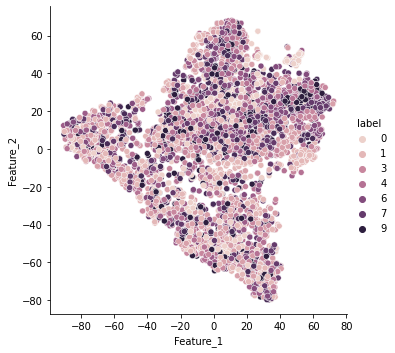

In [ ]:
import seaborn as sns
df = pd.DataFrame(dict(Feature_1=X_tsne[:,0], Feature_2=X_tsne[:,1], label=y))
sns.relplot(x='Feature_1', y="Feature_2",hue='label',data=df)

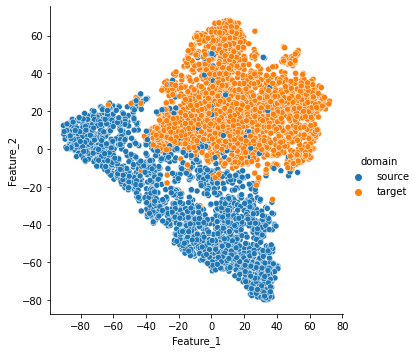

In [ ]:
import seaborn as sns
df = pd.DataFrame(dict(Feature_1=X_tsne[:,0], Feature_2=X_tsne[:,1], domain=D))
sns.relplot(x='Feature_1', y="Feature_2",hue='domain',data=df)

# MNIST-M → USPS

In [ ]:
image_size = 28
batch_size = 64
num_epochs = 10
lr = 0.01
momentum = 0.9
weight_decay = 1e-6
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")


In [ ]:
tfm = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

## Prepare dataset

In [ ]:
class MNISTMmodel(nn.Module):
    """ MNIST-M architecture
    """
    def __init__(self):
        super(MNISTMmodel, self).__init__()
        self.restored = False

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=(5, 5)),  # 3 28 28, 32 24 24
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),  # 32 12 12
            nn.Conv2d(in_channels=32, out_channels=48,
                      kernel_size=(5, 5)),  # 48 8 8
            nn.BatchNorm2d(48),
            nn.Dropout2d(0.8), # 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),  # 48 4 4
        )

        self.classifier = nn.Sequential(
            nn.Linear(48*4*4, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(inplace=True),
            nn.Linear(300, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
        )

        self.discriminator = nn.Sequential(
            nn.Linear(48*4*4, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(inplace=True),
            nn.Linear(300, 2),
        )

    def forward(self, d_classifier, input_data, alpha = 1.0):
        input_data = input_data.expand(input_data.data.shape[0], input_data.data.shape[1], 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, 48 * 4 * 4)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.classifier(feature)
        if d_classifier:
          domain_output = self.discriminator(reverse_feature)

          return class_output, domain_output
        else:
          return class_output

In [ ]:
s_train_set = Image_Dataset('/content/hw2_data/digits/mnistm/', train='train', trans=tfm)
s_test_set = Image_Dataset('/content/hw2_data/digits/mnistm/', train='test', trans=tfm)

t_train_set = Image_Dataset('/content/hw2_data/digits/usps/', train='train', trans=tfm)
t_test_set = Image_Dataset('/content/hw2_data/digits/usps/', train='test', trans=tfm)

s_data_loader = DataLoader(s_train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
s_data_loader_eval = DataLoader(s_test_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
t_data_loader = DataLoader(t_train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
t_data_loader_eval = DataLoader(t_test_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

# dann = init_model(net=SVHNmodel(d_classifier=False), restore=None)

dann = MNISTMmodel()
dann.apply(weights_init)
dann.to(device)

optimizer = optim.SGD(dann.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Training on source domain and target domain data

In [ ]:
dann = train(dann, s_data_loader, t_data_loader, t_data_loader_eval, device, num_epochs, 200, 'MNIST-M_to_USPS')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [   1/10] Step [200/114]: src_loss_class=1.206257, src_loss_domain=0.711536, tgt_loss_domain=0.662460, loss=2.580253
Epoch [   1/10] Step [400/114]: src_loss_class=0.878062, src_loss_domain=0.704090, tgt_loss_domain=0.662479, loss=2.244631
Epoch [   1/10] Step [600/114]: src_loss_class=0.765389, src_loss_domain=0.686561, tgt_loss_domain=0.619042, loss=2.070991
Epoch [   1/10] Step [800/114]: src_loss_class=0.686769, src_loss_domain=0.689714, tgt_loss_domain=0.639087, loss=2.015570
Avg Loss = 0.010186, Avg Accuracy = 79.07%, 47445.0/60000, Avg Domain Accuracy = 91.393333%
Avg Loss = 0.011991, Avg Accuracy = 76.93%, 1544.0/2007, Avg Domain Accuracy = 19.033383%
Epoch [   2/10] Step [200/114]: src_loss_class=0.633060, src_loss_domain=0.697427, tgt_loss_domain=0.593278, loss=1.923765
Epoch [   2/10] Step [400/114]: src_loss_class=0.822981, src_loss_domain=0.639327, tgt_loss_domain=0.653069, loss=2.115377
Epoch [   2/10] Step [600/114]: src_loss_class=0.806042, src_loss_domain=0.60424

## Predict on traget domain

In [ ]:
dann = MNISTMmodel()
dann.load_state_dict(torch.load('/content/drive/MyDrive/HW2/model/DANN/MNIST-M_to_USPS_best.pth'))

test(dann.to(device), t_data_loader_eval, device, flag='target', train_source=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Avg Loss = 0.011991, Avg Accuracy = 76.93%, 1544.0/2007, Avg Domain Accuracy = 19.033383%


(0.01199074434770775, 0.7693074240159442, 0.19033383158943698)

## Improved model

In [ ]:
class MNISTMmodel(nn.Module):
    """ MNIST-M architecture
    """
    def __init__(self):
        super(MNISTMmodel, self).__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=(5, 5)),  # 3 28 28, 32 24 24
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),  # 32 12 12
            nn.Conv2d(in_channels=32, out_channels=48,
                      kernel_size=(5, 5)),  # 48 8 8
            nn.BatchNorm2d(48),
            nn.Dropout2d(0.5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),  # 48 4 4
        )

        self.classifier = nn.Sequential(
            nn.Linear(48*4*4, 100),
            nn.Linear(100, 10),
        )

        self.discriminator = nn.Sequential(
            nn.Linear(48*4*4, 100),
            nn.Linear(100, 2),
        )

    def forward(self, d_classifier, input_data, alpha = 1.0):
        input_data = input_data.expand(input_data.data.shape[0], input_data.data.shape[1], 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, 48 * 4 * 4)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.classifier(feature)
        if d_classifier:
          domain_output = self.discriminator(reverse_feature)

          return class_output, domain_output
        else:
          return class_output

In [ ]:
dann = MNISTMmodel()
dann.apply(weights_init)
dann.to(device)

optimizer = optim.SGD(dann.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [ ]:
dann = train(dann, s_data_loader, t_data_loader, t_data_loader_eval, device, num_epochs, 200, 'MNIST-M_to_USPS_improved')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [   1/10] Step [200/114]: src_loss_class=0.896174, src_loss_domain=0.466718, tgt_loss_domain=0.396531, loss=1.759423
Epoch [   1/10] Step [400/114]: src_loss_class=0.795541, src_loss_domain=0.444699, tgt_loss_domain=0.513166, loss=1.753406
Epoch [   1/10] Step [600/114]: src_loss_class=0.560501, src_loss_domain=0.453055, tgt_loss_domain=0.617148, loss=1.630703
Epoch [   1/10] Step [800/114]: src_loss_class=0.724010, src_loss_domain=0.842668, tgt_loss_domain=0.621458, loss=2.188135
Avg Loss = 0.010502, Avg Accuracy = 81.00%, 48599.0/60000, Avg Domain Accuracy = 90.013333%
Avg Loss = 0.014127, Avg Accuracy = 77.83%, 1562.0/2007, Avg Domain Accuracy = 82.660688%
Epoch [   2/10] Step [200/114]: src_loss_class=0.840954, src_loss_domain=0.473909, tgt_loss_domain=0.515638, loss=1.830500
Epoch [   2/10] Step [400/114]: src_loss_class=0.762980, src_loss_domain=0.572358, tgt_loss_domain=0.631896, loss=1.967234
Epoch [   2/10] Step [600/114]: src_loss_class=0.782385, src_loss_domain=0.54025

In [ ]:
dann = MNISTMmodel()
dann.load_state_dict(torch.load('/content/drive/MyDrive/HW2/model/DANN/MNIST-M_to_USPS_improved_best.pth'))

test(dann.to(device), t_data_loader_eval, device, flag='target', train_source=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Avg Loss = 0.014437, Avg Accuracy = 79.72%, 1600.0/2007, Avg Domain Accuracy = 41.604385%


(0.014437156882996457, 0.7972097658196313, 0.41604384653712007)

## TSNE

In [ ]:
test_set = Tsen_Dataset('/content/tsne/mnistm_usps', trans=tfm)
data_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

In [ ]:
out = []

# return list siez of (lenght = N/batchsize), (batchsize x layer output dimension) on every list item.  
# Get the output from specific layer.
def hook(module, input, output):
  out.append(output) 

dann = MNISTMmodel(batchnorm=True, dropout=True)
dann.load_state_dict(torch.load('/content/drive/MyDrive/HW2/model/DANN/MNIST-M_to_USPS_improved_best.pth'))
dann.feature.register_forward_hook(hook) # Add this line that you can automatically store the specific output.
dann.apply(weights_init)
dann.to(device)
dann.eval()

latents = []
y_label = []
y_domain = []

for batch in data_loader:
   
  imgs, label, domain = batch
  y_label.append(label)
  y_domain.append(domain)

  # Using torch.no_grad() accelerates the forward process.
  with torch.no_grad():
    pred = dann(True, imgs.to(device)) # The shape of logits is batchsize x layer output dimension. 


In [ ]:
out[0].shape

torch.Size([1, 48, 4, 4])

In [ ]:
X = []
for i in out:
  X.append(i[0].cpu().numpy().reshape(1, -1)[0])
X = np.array(X)

y = []
for i in y_label:
    y.append(int(i[0]))
y = np.array(y)

D = []
for i in y_domain:
  if int(i[0]) == 0:
    D.append('source')
  else:
    D.append('target')
D = np.array(D)


print(X.shape)

# https://mortis.tech/2019/11/program_note/664/

import matplotlib.pyplot as plt
from sklearn import manifold, datasets

# # t-SNE
X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1, n_iter=2000).fit_transform(X)

(4000, 768)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.002s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 4000 samples in 0.656s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.143625
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.421150
[t-SNE] KL divergence after 2000 iterations: 1.435083


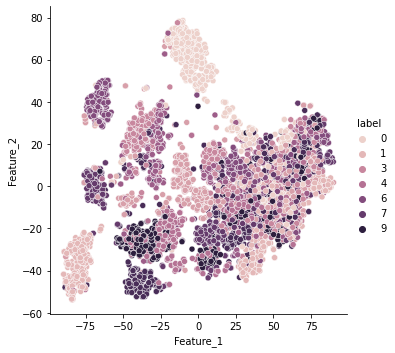

In [ ]:
import seaborn as sns
df = pd.DataFrame(dict(Feature_1=X_tsne[:,0], Feature_2=X_tsne[:,1], label=y))
sns.relplot(x='Feature_1', y="Feature_2",hue='label',data=df)

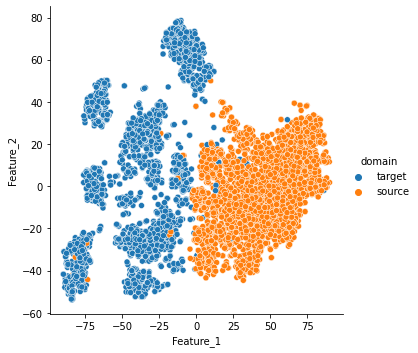

In [ ]:
import seaborn as sns
df = pd.DataFrame(dict(Feature_1=X_tsne[:,0], Feature_2=X_tsne[:,1], domain=D))
sns.relplot(x='Feature_1', y="Feature_2",hue='domain',data=df)

# USPS → SVHN

In [9]:
image_size = 28
batch_size = 64
num_epochs = 10
lr = 0.002
momentum = 0.9
weight_decay = 1e-6
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")


In [10]:
tfm_3 = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

tfm_1 = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

## Prepare dataset and model 

In [11]:
class USPSMmodel(nn.Module):
    """ USPS architecture"""
    def __init__(self):
        super(USPSMmodel, self).__init__()
        self.restored = False
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=(5, 5)),  # 1 28 28, 32 24 24
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),  # 32 12 12
            nn.Conv2d(in_channels=32, out_channels=24,
                      kernel_size=(5, 5)),  # 24 8 8
            nn.BatchNorm2d(24),
            nn.Dropout2d(0.8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),  # 24 4 4
            )

        self.classifier = nn.Sequential(
            nn.Linear(24*4*4, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(inplace=True),
            nn.Linear(24, 10),
            )

        self.discriminator = nn.Sequential(
            nn.Linear(24*4*4, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(inplace=True),
            nn.Linear(24, 2),
            )

    def forward(self, d_classifier, input_data, alpha = 1.0):
        input_data = input_data.expand(input_data.data.shape[0], input_data.data.shape[1], 28, 28)     
        feature = self.feature(input_data)
        feature = feature.view(-1, feature.shape[1] * 4 * 4)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.classifier(feature)
        if d_classifier:
          domain_output = self.discriminator(reverse_feature)

          return class_output, domain_output
        else:
          return class_output

In [12]:
s_train_set = Image_Dataset('/content/hw2_data/digits/usps/', train='train', trans=tfm_1)
s_test_set = Image_Dataset('/content/hw2_data/digits/usps/', train='test', trans=tfm_1)

t_train_set = Image_Dataset('/content/hw2_data/digits/svhn/', train='train', trans=tfm_3)
t_test_set = Image_Dataset('/content/hw2_data/digits/svhn/', train='test', trans=tfm_3)

s_data_loader = DataLoader(s_train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
s_data_loader_eval = DataLoader(s_test_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
t_data_loader = DataLoader(t_train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
t_data_loader_eval = DataLoader(t_test_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

# dann = init_model(net=SVHNmodel(d_classifier=False), restore=None)

dann = USPSMmodel()
dann.apply(weights_init)
dann.to(device)

optimizer = optim.SGD(dann.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Training on source domain and target domain data

In [ ]:
dann = train(dann, s_data_loader, t_data_loader, t_data_loader_eval, device, num_epochs, 200, 'USPS_to_SVHN')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KeyboardInterrupt: ignored

## Predict on traget domain

In [13]:
dann = USPSMmodel()
dann.load_state_dict(torch.load('/content/drive/MyDrive/HW2/model/DANN/USPS_to_SVHN_best.pth'))

test(dann.to(device), t_data_loader_eval, device, flag='target', train_source=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Avg Loss = 0.034337, Avg Accuracy = 31.26%, 8138.0/26032, Avg Domain Accuracy = 99.777197%


(0.03433716306308331, 0.31261524277811925, 0.9977719729563614)

## Improved model

In [ ]:
tfm_1 = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomRotation(15),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

tfm_3 = transforms.Compose([
    transforms.CenterCrop((28, 20)),
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

s_train_set = Image_Dataset('/content/hw2_data/digits/usps/', train='train', trans=tfm_1)
s_data_loader = DataLoader(s_train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

t_train_set = Image_Dataset('/content/hw2_data/digits/svhn/', train='train', trans=tfm_3)
t_test_set = Image_Dataset('/content/hw2_data/digits/svhn/', train='test', trans=tfm_3)
t_data_loader = DataLoader(t_train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
t_data_loader_eval = DataLoader(t_test_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
a = transforms.Compose([
    transforms.CenterCrop((28, 20)),
    transforms.Resize((28,28)),
        transforms.Grayscale(num_output_channels=3),
])
a(Image.open('/content/hw2_data/digits/svhn/train/' + os.listdir('/content/hw2_data/digits/svhn/train')[2]))

In [ ]:
Image.open('/content/hw2_data/digits/svhn/train/' + os.listdir('/content/hw2_data/digits/svhn/train')[2])

In [ ]:
dann = USPSMmodel()
dann.feature[4] = nn.Conv2d(32, 24, kernel_size=(5, 5), stride=(1, 1))
dann.feature[5] = nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
dann.feature[6] = nn.Dropout2d(p=0.5, inplace=False)

dann.classifier[0] = nn.Linear(in_features=24*4*4, out_features=24, bias=True)
dann.classifier[1] = nn.BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
dann.classifier[2] = nn.Sigmoid()
dann.classifier[3] = nn.Linear(in_features=24, out_features=10, bias=True)

dann.discriminator[0] = nn.Linear(in_features=24*4*4, out_features=24, bias=True)
dann.discriminator[1] = nn.BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
dann.discriminator[2] = nn.Sigmoid()
dann.discriminator[3] = nn.Linear(in_features=24, out_features=2, bias=True)

dann

USPSMmodel(
  (feature): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 24, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout2d(p=0.5, inplace=False)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=384, out_features=24, bias=True)
    (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=24, out_features=10, bias=True)
  )
  (discriminator): Sequential(
    (0): Linear(in_features=384, out_features=24, bias=True)
    (1): BatchNorm1d(24, e

In [ ]:

dann.apply(weights_init)
dann.to(device)

optimizer = optim.SGD(dann.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [ ]:
dann = train(dann, s_data_loader, t_data_loader, t_data_loader_eval, device, num_epochs, 200, 'USPS_to_SVHN_improved')

In [ ]:
dann = USPSMmodel()
dann.feature[4] = nn.Conv2d(32, 24, kernel_size=(5, 5), stride=(1, 1))
dann.feature[5] = nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
dann.feature[6] = nn.Dropout2d(p=0.5, inplace=False)

dann.classifier[0] = nn.Linear(in_features=24*4*4, out_features=24, bias=True)
dann.classifier[1] = nn.BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
dann.classifier[2] = nn.Sigmoid()
dann.classifier[3] = nn.Linear(in_features=24, out_features=10, bias=True)

dann.discriminator[0] = nn.Linear(in_features=24*4*4, out_features=24, bias=True)
dann.discriminator[1] = nn.BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
dann.discriminator[2] = nn.Sigmoid()
dann.discriminator[3] = nn.Linear(in_features=24, out_features=2, bias=True)

dann.load_state_dict(torch.load('/content/drive/MyDrive/HW2/model/DANN/USPS_to_SVHN_improved_best.pth'))
test(dann.to(device), t_data_loader_eval, device, flag='target', train_source=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Avg Loss = 0.029721, Avg Accuracy = 37.26%, 9700.0/26032, Avg Domain Accuracy = 53.157652%


(0.02972140726899544, 0.37261831591886907, 0.5315765212046711)

## TSNE

In [ ]:
test_set = Tsen_Dataset('/content/tsne/usps_svhn', trans=tfm_3)
data_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

In [ ]:
out = []

# return list siez of (lenght = N/batchsize), (batchsize x layer output dimension) on every list item.  
# Get the output from specific layer.
def hook(module, input, output):
  out.append(output) 

dann = USPSMmodel()
dann.feature[4] = nn.Conv2d(32, 24, kernel_size=(5, 5), stride=(1, 1))
dann.feature[5] = nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
dann.feature[6] = nn.Dropout2d(p=0.5, inplace=False)
dann.classifier[0] = nn.Linear(in_features=24*4*4, out_features=24, bias=True)
dann.classifier[1] = nn.BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
dann.classifier[2] = nn.Sigmoid()
dann.classifier[3] = nn.Linear(in_features=24, out_features=10, bias=True)
dann.discriminator[0] = nn.Linear(in_features=24*4*4, out_features=24, bias=True)
dann.discriminator[1] = nn.BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
dann.discriminator[2] = nn.Sigmoid()
dann.discriminator[3] = nn.Linear(in_features=24, out_features=2, bias=True)
dann.load_state_dict(torch.load('/content/drive/MyDrive/HW2/model/DANN/USPS_to_SVHN_improved_best.pth'))
dann.feature.register_forward_hook(hook) # Add this line that you can automatically store the specific output.
dann.apply(weights_init)
dann.to(device)
dann.eval()

latents = []
y_label = []
y_domain = []

for batch in data_loader:
   
  imgs, label, domain = batch
  y_label.append(label)
  y_domain.append(domain)

  # Using torch.no_grad() accelerates the forward process.
  with torch.no_grad():
    pred = dann(True, imgs.to(device)) # The shape of logits is batchsize x layer output dimension. 


In [ ]:
X = []
for i in out:
  X.append(i[0].cpu().numpy().reshape(1, -1)[0])
X = np.array(X)

y = []
for i in y_label:
    y.append(int(i[0]))
y = np.array(y)

D = []
for i in y_domain:
  if int(i[0]) == 0:
    D.append('source')
  else:
    D.append('target')
D = np.array(D)


print(X.shape)

# https://mortis.tech/2019/11/program_note/664/

import matplotlib.pyplot as plt
from sklearn import manifold, datasets

# # t-SNE
X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1, n_iter=2000).fit_transform(X)

(4000, 384)


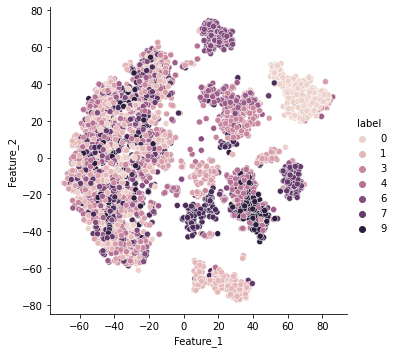

In [ ]:
import seaborn as sns
#Data Visualization
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  #Normalize

df = pd.DataFrame(dict(Feature_1=X_tsne[:,0], Feature_2=X_tsne[:,1], label=y))
# df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label',colors=['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'], figsize=(20,20))

# plt.xticks([])
# plt.yticks([])
# plt.show()

sns.relplot(x='Feature_1', y="Feature_2",hue='label',data=df)

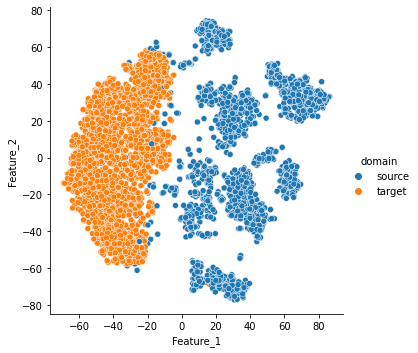

In [ ]:
import seaborn as sns
#Data Visualization
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  #Normalize

df = pd.DataFrame(dict(Feature_1=X_tsne[:,0], Feature_2=X_tsne[:,1], domain=D))
# df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label',colors=['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'], figsize=(20,20))

# plt.xticks([])
# plt.yticks([])
# plt.show()

sns.relplot(x='Feature_1', y="Feature_2",hue='domain',data=df)